In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
import torch.nn as nn
from dataclasses import dataclass
%matplotlib inline

In [2]:
raw_words = open('first_names.all.txt').read().splitlines()
raw_words[:8]

["a'isha",
 "a'ishah",
 'a-jay',
 "aa'isha",
 "aa'ishah",
 'aaban',
 'aabas',
 'aabha']

In [3]:
words = []
for word in raw_words:
    if word.isalpha():
        words.append(word)

In [4]:
words[:8]

['aaban', 'aabas', 'aabha', 'aabia', 'aabid', 'aabidah', 'aabidammar', 'aabir']

In [5]:
block_size = 3

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)

chars_n = len(chars) + 1

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ß', 28: 'à', 29: 'á', 30: 'â', 31: 'ã', 32: 'ä', 33: 'å', 34: 'æ', 35: 'ç', 36: 'è', 37: 'é', 38: 'ê', 39: 'ë', 40: 'ì', 41: 'í', 42: 'î', 43: 'ï', 44: 'ð', 45: 'ñ', 46: 'ò', 47: 'ó', 48: 'ô', 49: 'õ', 50: 'ö', 51: 'ø', 52: 'ù', 53: 'ú', 54: 'û', 55: 'ü', 56: 'ý', 57: 'þ', 58: 'ā', 59: 'ă', 60: 'ą', 61: 'ć', 62: 'č', 63: 'ď', 64: 'đ', 65: 'ē', 66: 'ė', 67: 'ę', 68: 'ě', 69: 'ğ', 70: 'ģ', 71: 'ī', 72: 'ı', 73: 'ĳ', 74: 'ķ', 75: 'ļ', 76: 'ľ', 77: 'ł', 78: 'ņ', 79: 'ň', 80: 'ő', 81: 'ř', 82: 'ş', 83: 'ţ', 84: 'ť', 85: 'ū', 86: 'ż', 87: 'ž', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 

In [7]:
@dataclass
class CharDataset:
    X_train: torch.Tensor
    Y_train: torch.Tensor
    X_val: torch.Tensor
    Y_val: torch.Tensor
    X_test: torch.Tensor
    Y_test: torch.Tensor

    @classmethod
    def build(cls, words, stoi, block_size, splits=(0.8, 0.1, 0.1), device='cuda'):
        random.shuffle(words)
        n = len(words)
        n1 = int(splits[0] * n)
        n2 = n1 + int(splits[1] * n)
        splits_words = [words[:n1], words[n1:n2], words[n2:]]

        def build_xy(subset):
            X, Y = [], []
            for w in subset:
                context = [0] * block_size
                for ch in w + '.':
                    ix = stoi[ch]
                    X.append(context)
                    Y.append(ix)
                    context = context[1:] + [ix]
            return torch.tensor(X, device=device), torch.tensor(Y, device=device)

        X_train, Y_train = build_xy(splits_words[0])
        X_val, Y_val = build_xy(splits_words[1])
        X_test, Y_test = build_xy(splits_words[2])

        return cls(X_train, Y_train, X_val, Y_val, X_test, Y_test)

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

dataset = CharDataset.build(words, stoi, block_size)

In [8]:
dataset.X_val[0:10], dataset.Y_val[:10]

(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13,  1],
         [13,  1,  7],
         [ 1,  7, 14],
         [ 7, 14,  5],
         [14,  5, 18],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22]], device='cuda:0'),
 tensor([13,  1,  7, 14,  5, 18,  0,  1, 22, 18], device='cuda:0'))

In [26]:
class SimpleCharModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden1, hidden2, hidden3, block_size, dropout_p=0.5):
        super().__init__()
        self.block_size = block_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.fc1 = nn.Linear(block_size * embedding_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)

        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)

        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)

        self.fc_out = nn.Linear(hidden3, vocab_size)
        self.dropout = nn.Dropout(dropout_p)

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        logits = self.fc_out(x)
        return logits

    def _log_losses(self, epoch, train_loss, val_loss=None):
        self.train_losses.append((epoch, train_loss))
        if val_loss is not None:
            self.val_losses.append((epoch, val_loss))

    def train_model(self, dataset, epochs=100, lr=0.01, print_every=10):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            if epoch > 50:
                lr /= 10

            self.train()
            logits = self(dataset.X_train)
            loss = F.cross_entropy(logits, dataset.Y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            val_loss = None
            if epoch % print_every == 0 or epoch == epochs - 1:
                self.eval()
                val_loss = self.evaluate_loss(dataset.X_val, dataset.Y_val)
                print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            self._log_losses(epoch, loss.item(), val_loss)

    def evaluate_loss(self, X, Y):
        with torch.no_grad():
            logits = self(X)
            loss = F.cross_entropy(logits, Y)
        return loss.item()

    def plot_loss_history(self):
        plt.figure(figsize=(10, 5))

        if self.train_losses:
            train_epochs, train_vals = zip(*self.train_losses)
            plt.plot(train_epochs, train_vals, label="Train Loss")

        if self.val_losses:
            val_epochs, val_vals = zip(*self.val_losses)
            plt.plot(val_epochs, val_vals, 'o-', label="Validation Loss")

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss History')
        plt.legend()
        plt.grid(True)
        plt.show()



In [27]:
model = SimpleCharModel(vocab_size=chars_n, embedding_dim=20, hidden1=200, hidden2=400, hidden3=200, block_size=block_size).cuda()

In [28]:
model.train_model(dataset, epochs=100, lr=0.01, print_every=5)

Epoch 0, Train Loss: 4.6564, Val Loss: 4.1145
Epoch 5, Train Loss: 2.7428, Val Loss: 2.7896
Epoch 10, Train Loss: 2.6335, Val Loss: 2.5901
Epoch 15, Train Loss: 2.5784, Val Loss: 2.5183
Epoch 20, Train Loss: 2.5498, Val Loss: 2.4960
Epoch 25, Train Loss: 2.5291, Val Loss: 2.4758
Epoch 30, Train Loss: 2.5149, Val Loss: 2.4608
Epoch 35, Train Loss: 2.5020, Val Loss: 2.4483
Epoch 40, Train Loss: 2.4914, Val Loss: 2.4375
Epoch 45, Train Loss: 2.4828, Val Loss: 2.4289
Epoch 50, Train Loss: 2.4758, Val Loss: 2.4207
Epoch 55, Train Loss: 2.4682, Val Loss: 2.4142
Epoch 60, Train Loss: 2.4629, Val Loss: 2.4080
Epoch 65, Train Loss: 2.4581, Val Loss: 2.4026
Epoch 70, Train Loss: 2.4524, Val Loss: 2.3976
Epoch 75, Train Loss: 2.4483, Val Loss: 2.3927
Epoch 80, Train Loss: 2.4437, Val Loss: 2.3885
Epoch 85, Train Loss: 2.4399, Val Loss: 2.3848
Epoch 90, Train Loss: 2.4359, Val Loss: 2.3815
Epoch 95, Train Loss: 2.4326, Val Loss: 2.3785
Epoch 99, Train Loss: 2.4304, Val Loss: 2.3763


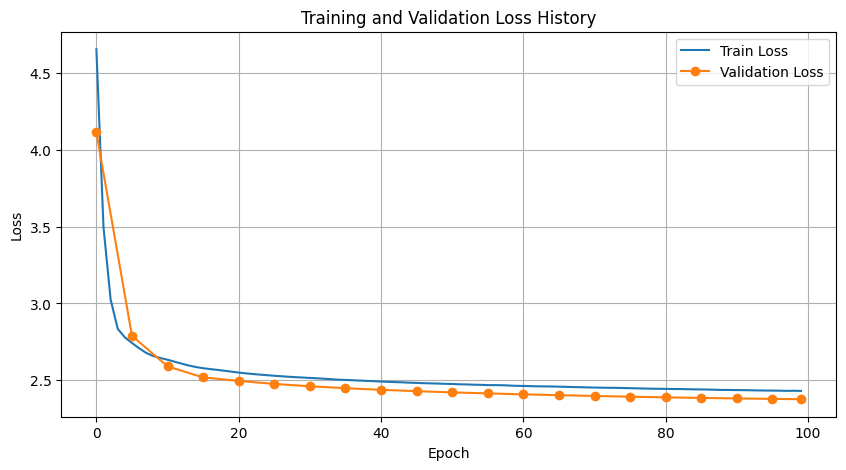

In [29]:
model.plot_loss_history()

In [44]:
def sample_from_model(model, stoi, itos, block_size, num_samples=20, device='cuda'):
    model.eval()
    for _ in range(num_samples):
        context = [0] * block_size  # initialize with all padding (start)
        name = ''
        while True:
            x = torch.tensor([context], dtype=torch.long, device=device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            if ix == 0:
                break
            name += itos[ix]
            context = context[1:] + [ix]
        print(name)

# Sample 20 names
sample_from_model(model, stoi, itos, block_size, num_samples=20)


şestirtanika
fler
neil
mulde
asher
esz
miry
ley
mcdi
barjhoattiyose
nairatla
vallya
moshan
havantelia
shaijasembátitea
branelline
mathana
heemeke
stad
mae


In [45]:
0

0